In [ ]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
from functools import partial

AUTO = tf.data.experimental.AUTOTUNE
import warnings
warnings.filterwarnings('ignore')

In [ ]:
images = glob('train_cancer/*/*.jpg')
len(images)

270

In [ ]:
#replace backslash with forward slash to avoid unexpected errors
images = [path.replace('\\', '/') for path in images]
df = pd.DataFrame({'filepath': images})
df['label'] = df['filepath'].str.split('/', expand=True)[1]
df.head()

,filepath,label
0,train_cancer/benign/30.jpg,benign
1,train_cancer/benign/19.jpg,benign
2,train_cancer/benign/25.jpg,benign
3,train_cancer/benign/14.jpg,benign
4,train_cancer/benign/41.jpg,benign


In [ ]:
df['label_bin'] = np.where(df['label'].values == 'malignant', 1, 0)
df.head()

,filepath,label,label_bin
0,train_cancer/benign/30.jpg,benign,0
1,train_cancer/benign/19.jpg,benign,0
2,train_cancer/benign/25.jpg,benign,0
3,train_cancer/benign/14.jpg,benign,0
4,train_cancer/benign/41.jpg,benign,0


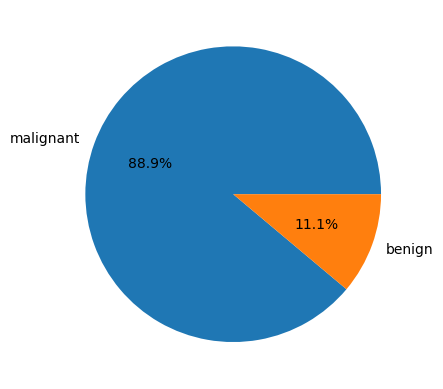

In [ ]:
x = df['label'].value_counts()
plt.pie(x.values,
		labels=x.index,
		autopct='%1.1f%%')
plt.show()

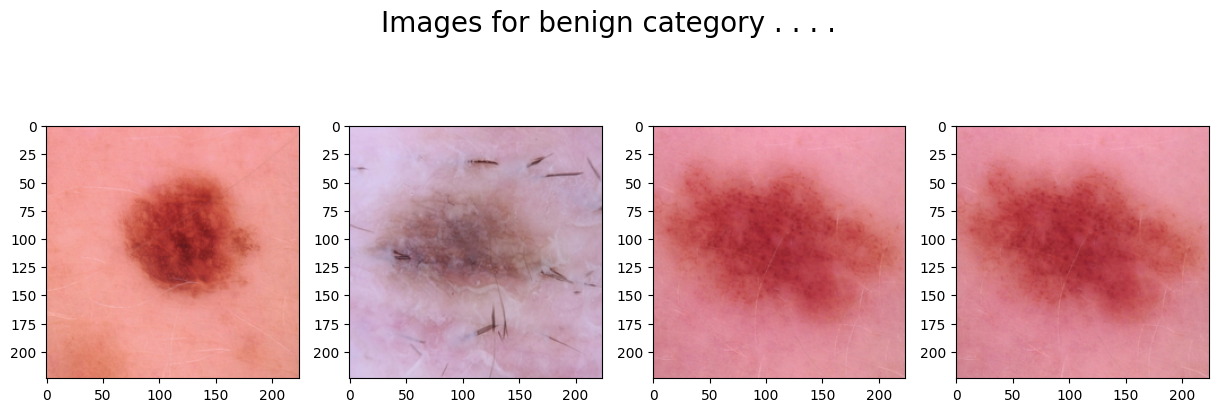

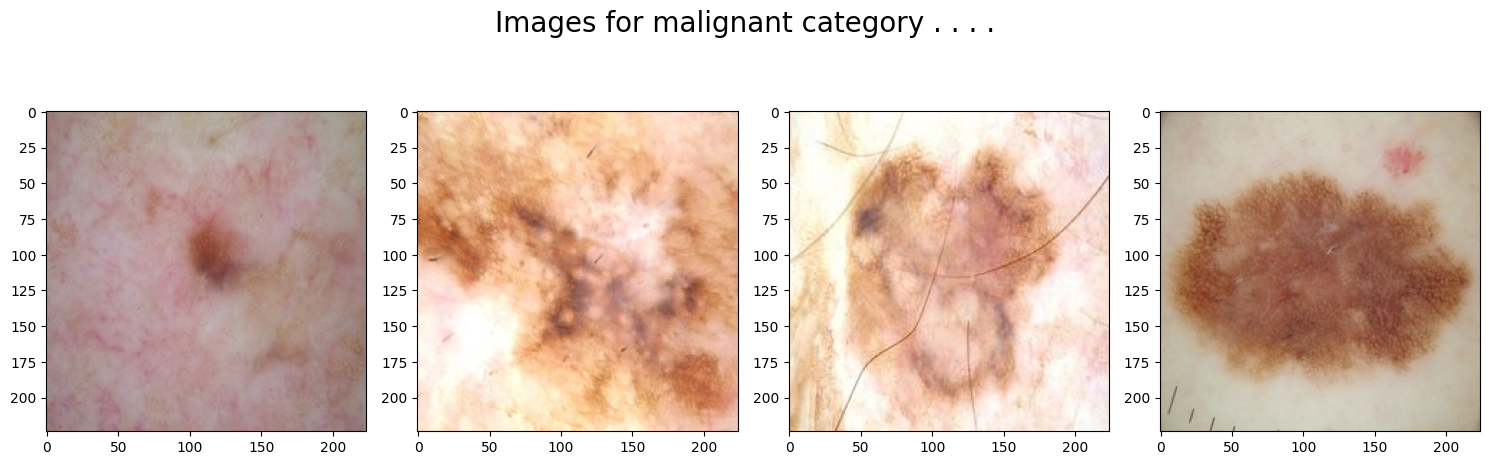

In [ ]:
for cat in df['label'].unique():
	temp = df[df['label'] == cat]

	index_list = temp.index
	fig, ax = plt.subplots(1, 4, figsize=(15, 5))
	fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
	for i in range(4):
		index = np.random.randint(0, len(index_list))
		index = index_list[index]
		data = df.iloc[index]

		image_path = data[0]

		img = np.array(Image.open(image_path))
		ax[i].imshow(img)
plt.tight_layout()
plt.show()

In [ ]:
features = df['filepath']
target = df['label_bin']

X_train, X_val,	Y_train, Y_val = train_test_split(features, target,
									test_size=0.15,
									random_state=10)

X_train.shape, X_val.shape

((229,), (41,))

In [ ]:
def decode_image(filepath, label=None):

	img = tf.io.read_file(filepath)
	img = tf.image.decode_jpeg(img)
	img = tf.image.resize(img, [224, 224])
	img = tf.cast(img, tf.float32) / 255.0

	if label == 0:
		Label = 0
	else:
		Label = 1

	return img, Label

In [ ]:
train_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_train, Y_train))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

val_ds = (
	tf.data.Dataset
	.from_tensor_slices((X_val, Y_val))
	.map(decode_image, num_parallel_calls=AUTO)
	.batch(32)
	.prefetch(AUTO)
)

In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7

pre_trained_model = EfficientNetB7(
	input_shape=(224, 224, 3),
	weights='imagenet',
	include_top=False
)

for layer in pre_trained_model.layers:
	layer.trainable = False

In [ ]:
from tensorflow.keras import Model

inputs = layers.Input(shape=(224, 224, 3))
x = layers.Flatten()(inputs)

x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.BatchNormalization()(x)
outputs = layers.Dense(1, activation='sigmoid')(x)

model = Model(inputs, outputs)

In [ ]:
model.compile(
	loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
	optimizer='adam',
	metrics=['AUC']
)

In [ ]:
history = model.fit(train_ds,
					validation_data=val_ds,
					epochs=5,
					verbose=1)

Epoch 1/5
8/8 [==============================] - 8s 745ms/step - loss: 0.8845 - auc: 0.6772 - val_loss: 2.4704 - val_auc: 0.5000
Epoch 2/5
8/8 [==============================] - 6s 697ms/step - loss: 0.6240 - auc: 0.8589 - val_loss: 0.8174 - val_auc: 0.4764
Epoch 3/5
8/8 [==============================] - 6s 693ms/step - loss: 0.5195 - auc: 0.9025 - val_loss: 1.2005 - val_auc: 0.4865
Epoch 4/5
8/8 [==============================] - 6s 723ms/step - loss: 0.4439 - auc: 0.9585 - val_loss: 0.7520 - val_auc: 0.5135
Epoch 5/5
8/8 [==============================] - 7s 925ms/step - loss: 0.3778 - auc: 0.9411 - val_loss: 0.6217 - val_auc: 0.5203


In [ ]:
hist_df = pd.DataFrame(history.history)
hist_df.head()

,loss,auc,val_loss,val_auc
0,0.884477,0.677150,2.470377,0.500000
1,0.624001,0.858943,0.817437,0.476351
2,0.519542,0.902520,1.200533,0.486486
3,0.443939,0.958507,0.752024,0.513514
4,0.377754,0.941076,0.621685,0.520270


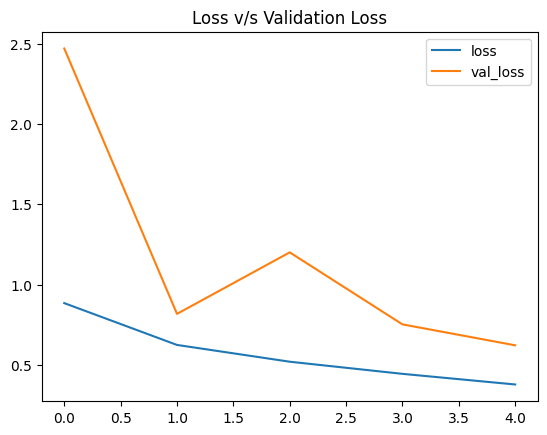

In [ ]:
hist_df['loss'].plot()
hist_df['val_loss'].plot()
plt.title('Loss v/s Validation Loss')
plt.legend()
plt.show()

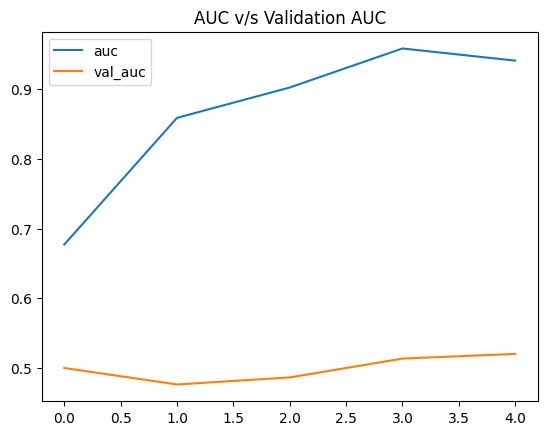

In [ ]:
hist_df['auc'].plot()
hist_df['val_auc'].plot()
plt.title('AUC v/s Validation AUC')
plt.legend()
plt.show()